In [2]:
%matplotlib inline

import os
import h5py
import numpy as np
import time

from scipy import signal
import matplotlib.pyplot as plt

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def read_block_from_dat(dat_file, ch_no, offset, bytes_count):
    """
    dat_file      path to the .dat file
    ch_no         total channel number, e.g. 64
    offset        in samples
    bytes_count   number of bytes to read
    """
    count = bytes_count * ch_no  # number of values to read
    offset_in_bytes = offset * ch_no * 2  # assuming int16 is 2 bytes
    block = np.fromfile(dat_file, dtype=np.int16, count=count, offset=offset_in_bytes)
    return block.reshape([bytes_count, ch_no])

In [41]:
b1 = read_block_from_dat(dat_path, ch_no, 0, 30000)
b1.shape, dat_path

((30000, 72),
 '/home/sobolev/nevermind/Andrey/code/sandbox/s1/013829_ppcSIT_2024-11-11_09-10-59.dat')

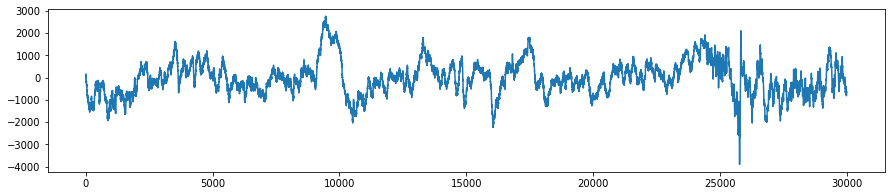

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(b1[:, 31])

## Config

In [5]:
# path to folder with kilosort files
sb_path = '/home/sobolev/nevermind/Andrey/code/sandbox/s1/'

kilo_path = '/home/sobolev/nevermind/Andrey/code/sandbox/s1/kilosort4'
dat_name = [x for x in os.listdir(os.path.dirname(kilo_path)) if x.endswith('.dat')][0]
dat_path = os.path.join(os.path.dirname(kilo_path), dat_name)

fil_path = os.path.join(sb_path, 'neurosuite', 'filebase.fil')

# destination for neurosuite files
dst_path = '/home/sobolev/nevermind/Andrey/code/sandbox/s1/neurosuite'
ch_no = 72  # number of channels recorded in the .DAT file
spk_sample_count = 50

shanks   = np.array([1, 2, 3, 4, 5])
channels = np.arange(64)
ch_shank_map = np.concatenate([
    1 * np.ones(32),
    2 * np.ones(8),
    3 * np.ones(8),
    4 * np.ones(8),
    5 * np.ones(8)
])

# channel_map = 
#     np.arange(32),
#     np.arange(32, 40),
#     np.arange(40, 48),
#     np.arange(48, 56),
#     np.arange(56, 64)
# ]

In [6]:
dp = '/home/sobolev/nevermind/AG_Pecka/data/raw/013829/013829_ppcSIT_2024-11-06_20-06-31'
for dirpath, dirnames, filenames in os.walk(dp):
    for filename in [f for f in filenames if f.endswith('.dat')]:
        print(os.path.join(dirpath, filename))

/home/sobolev/nevermind/AG_Pecka/data/raw/013829/013829_ppcSIT_2024-11-06_20-06-31/XXX013829_ppcSIT_2024-11-06_20-06-31.dat
/home/sobolev/nevermind/AG_Pecka/data/raw/013829/013829_ppcSIT_2024-11-06_20-06-31/013829_ppcSIT_2024-11-06_20-06-31.dat
/home/sobolev/nevermind/AG_Pecka/data/raw/013829/013829_ppcSIT_2024-11-06_20-06-31/2024-11-06_20-07-48/Record Node 117/experiment1/recording1/continuous/Rhythm_FPGA-114.0/continuous.dat


## 2Neurosuite

In [7]:
# load kilosorted spike times / clusters
s_times   = np.load(os.path.join(kilo_path, 'spike_times.npy'))  # all spike times of all clusters (1D array)
s_clust   = np.load(os.path.join(kilo_path, 'spike_clusters.npy'))  # IDs of clusters for each spike
templates = np.load(os.path.join(kilo_path, 'templates.npy'))  # cluster (unit), timepoints, channel

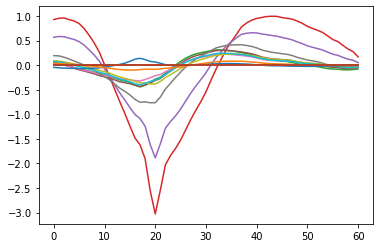

In [11]:
# test templates: plot all templates for all channels for selected cluster
for ts in templates[2].T:
    plt.plot(ts)

In [13]:
templates[2].shape

(61, 64)

In [13]:
# assign clusters to shanks using templates
clu_mapping = []  # 1D, shank id for each cluster
for template in templates:  # template IDs should match cluster IDs
    amplitudes = [t.max() - t.min() for t in template.T]
    best_channel = np.argmax(amplitudes) #+ channel_map[0][0]  # 0-based indexing, adjust to starting channel
    #clu_mapping.append(np.where(channel_map == best_channel)[0][0])
    clu_mapping.append(ch_shank_map[np.where(channels == best_channel)[0][0]])
clu_mapping = np.array(clu_mapping)

In [14]:
# split all spikes / cluster IDs into diff shanks
clu_per_shank, spk_per_shank = [], []
# for i, channels in enumerate(channel_map):
#     clu_ids = np.where(clu_mapping == i)[0]  # cluster numbers on this shank
#     bool_idxs = np.isin(s_clust, clu_ids)
#     clu_per_shank.append(s_clust[bool_idxs])
#     spk_per_shank.append(s_times[bool_idxs])
    
for shank in shanks:
    clu_ids = np.where(clu_mapping == shank)[0]
    bool_idxs = np.isin(s_clust, clu_ids)
    clu_per_shank.append(s_clust[bool_idxs])
    spk_per_shank.append(s_times[bool_idxs])

## Building .res, .clu, .fet

In [16]:
spk_per_shank[0].shape

(780889,)

In [69]:
# create .res files with spike times in samples
for i, data in enumerate(spk_per_shank):
    np.savetxt(os.path.join(dst_path, 'filebase.res.%d' % shanks[i]), np.array([data]).T, fmt='%d')

# create .clu files
for i, data in enumerate(clu_per_shank):
    f_path = os.path.join(dst_path, 'filebase.clu.%d' % shanks[i])
    np.savetxt(f_path, np.array([data]).T, fmt='%d', header=str(len(np.unique(data))), comments='')

# fake .fet files with features
spread = 500
for i, spk_times in enumerate(spk_per_shank):
    f_path = os.path.join(dst_path, 'filebase.fet.%d' % shanks[i])
    fet_count = len(np.where(ch_shank_map == i+1)[0]) * 3 + 1
    fet_mx = np.zeros([len(spk_times), fet_count])
    
    for j, spk_time in enumerate(spk_times):
        #spread = 5000 if clu_per_shank[i][j] == clu and j < 100 else 500
        fake_fet = np.random.randint(spread*2, size=fet_count - 1) - spread
        fake_fet = np.concatenate([fake_fet, [spk_time]])
        fet_mx[j] = fake_fet
    
    clu = clu_per_shank[i][0]  # some random cluster, induce larger spread for better visualization
    idxs = np.where(clu_per_shank[i] == clu)[0][:2]
    fet_mx[idxs[0]][:-1] = np.random.randint(spread*2*10, size=fet_count - 1) - spread*10
    fet_mx[idxs[1]][:-1] = np.random.randint(spread*2*10, size=fet_count - 1) - spread*10

    np.savetxt(f_path, fet_mx, fmt='%d', delimiter=' ', header=str(fet_count), comments='')

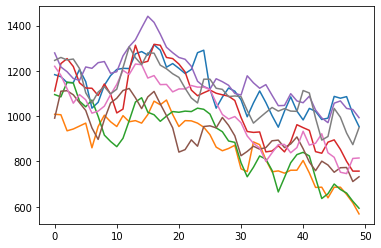

In [249]:
for sp in spk_flt:
    plt.plot(sp)

In [47]:
shanks

array([1, 2, 3, 4, 5])

In [83]:
shanks[4:]

array([5])

In [91]:
# create .spk files with waveforms
wf_to_display = 50
wf_in_samples = 50
total_samples = int(os.stat(dat_path).st_size/(2*ch_no))  # int16 is 2 bytes
    
#for shank in shanks:
for shank in shanks:
    t_start = time.time()
    
    channels_no = len(np.where(ch_shank_map == shank)[0])
    samples_no  = spk_sample_count
    spikes_no   = len(spk_per_shank[shank-1])
    spk_mx = np.zeros([spikes_no, samples_no, channels_no], dtype=np.int16)
    
    for j, spk in enumerate(spk_per_shank[shank-1]):
        #spk_all = read_block_from_dat(dat_path, ch_no, int(spk - spk_sample_count/2), spk_sample_count)
        
        s_start = int(spk - wf_in_samples/2)
        if s_start < 0 or s_start + wf_in_samples >= total_samples:
            continue
        
        spk_all = read_block_from_dat(fil_path, ch_no, s_start, wf_in_samples)  # 20 ms
        #spk_sm  = spk_all.reshape([int(wf_in_samples/wf_to_display), wf_to_display, ch_no]).mean(axis=0)
        #spk_sm  = signal.decimate(spk_all, int(wf_in_samples/wf_to_display), axis=0)
        
        spk_flt = spk_all.T[np.where(ch_shank_map == shank)[0]]
        spk_mx[j] = spk_flt.T
        
    f_path = os.path.join(dst_path, 'filebase.spk.%d' % shank)
    spk_mx.tofile(f_path)
    
    print("Shank %d is done, %d spikes, took %.2f seconds" % (shank, spikes_no, time.time() - t_start))

Shank 1 is done, 780889 spikes, took 1940.51 seconds
Shank 2 is done, 69443 spikes, took 245.99 seconds
Shank 3 is done, 89085 spikes, took 212.96 seconds
Shank 4 is done, 39922 spikes, took 90.54 seconds
Shank 5 is done, 34970 spikes, took 75.79 seconds


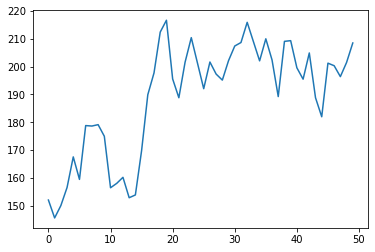

In [58]:
plt.plot(spk_sm[:, 0])

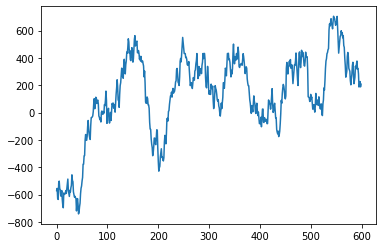

In [78]:
plt.plot(spk_all[:, 1])

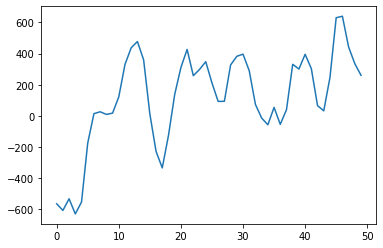

In [79]:
plt.plot(signal.decimate(spk_all, 12, axis=0)[:, 1])

In [25]:
channels_no, samples_no, spikes_no, ch_no, shank, spk_sample_count

(32, 50, 780889, 72, 1, 50)

## Read WFs from .spk - kilosort

In [273]:
sel_shank = 1  # shank number
spikes_no   = len(spk_per_shank[sel_shank-1])
samples_no  = spk_sample_count
channels_no = len(np.where(ch_shank_map == sel_shank)[0])

f_path = os.path.join(dst_path, 'filebase.spk.%d' % sel_shank)

spikes_no, samples_no, channels_no

(780889, 50, 32)

In [274]:
block = np.fromfile(f_path, dtype=np.int16)
spk_mx_r = block.reshape([spikes_no, samples_no, channels_no])
spk_mx_r.shape

(780889, 50, 32)

In [275]:
# cluster IDs for each spike on selected shank
clu_per_spike = clu_per_shank[sel_shank-1]
clu_per_spike.shape, np.unique(clu_per_spike)

((780889,),
 array([ 0,  1, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype=int32))

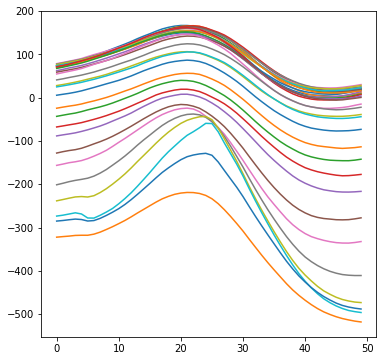

In [280]:
sel_clu = 40
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# plot means for each channel
for i in range(channels_no):
    sel_wfs = spk_mx_r[clu_per_spike == sel_clu][:, :, i].mean(axis=0)
    ax.plot(sel_wfs)

In [220]:
sf = spk_mx.flatten()

In [221]:
sf[:20]

array([-130, -280, -238,  -62,  -11,  -82,  -89,  -55,  -46, -153, -212,
         54,  143,   23,  -33,    3,  120,  -49,  -69,  139], dtype=int16)

In [223]:
spk_mx[0][0], spk_mx[0][1]

(array([-130, -280, -238,  -62,  -11,  -82,  -89,  -55], dtype=int16),
 array([ -46, -153, -212,   54,  143,   23,  -33,    3], dtype=int16))

In [151]:
int(spk - spk_sample_count/2), spk_sample_count/2

(71982240, 25.0)

In [93]:
spk_mx.shape

(34970, 50, 8)

In [92]:
spk_all.shape

(50, 64)

In [104]:
ch_no

72

## Test 

In [172]:
f_path

'/home/sobolev/nevermind/Andrey/code/sandbox/s1/neurosuite/filebase.spk.1'

In [179]:
i = 1  # shank number
spikes_no   = len(spk_per_shank[i-1])
samples_no  = spk_sample_count
channels_no = len(np.where(ch_shank_map == i)[0])

f_path = os.path.join(dst_path, 'filebase.spk.%d' % i)

block = np.fromfile(f_path, dtype=np.int16)
spk_mx_r = block.reshape([spikes_no, samples_no, channels_no])

(0.0008666666666666666, 13)

In [225]:
spikes_no   = 148484
samples_no  = 50
channels_no = 8

f_path = os.path.join(sb_path, 'spk_test', 'fb.spk.5')

block = np.fromfile(f_path, dtype=np.int16)
spk_mx_r = block.reshape([spikes_no, samples_no, channels_no])

In [226]:
spk_mx_r.shape

(148484, 50, 8)

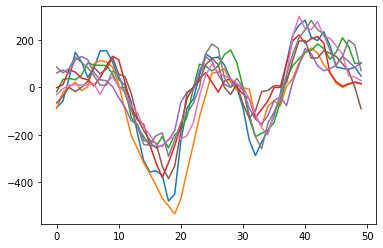

In [237]:
for wf in spk_mx_r[89].T:
    plt.plot(wf)

In [198]:
np.where(clu_per_shank[i-1] == 41)[0][:20]

array([  4,  15,  18,  34,  42,  54,  64,  71,  80,  86,  88,  89,  91,
       100, 104, 107, 112, 113, 130, 143])

In [217]:
spk_mx_r.shape

(780889, 50, 32)

0.20116666666666666 41


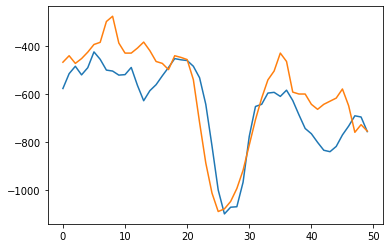

In [215]:
spk_id = 100
s_time = spk_per_shank[i-1][spk_id]
print(s_time/30000, clu_per_shank[i-1][spk_id])

for wf in spk_mx_r[spk_id].T:
    plt.plot(wf)

In [115]:
s_times.shape, s_clust.shape

((1014309,), (1014309,))

In [81]:
np.array([len(sh) for sh in spk_per_shank]).sum()

1014309

In [89]:
sum(1 for _ in open(os.path.join(dst_path, 'filebase.fet.%d' % 1)))

780890

In [ ]:
832949

In [88]:
len(np.where(ch_shank_map == 1)[0]) * 3 + 1

97

In [119]:
clu_mapping

array([1., 1., 2., 2., 3., 3., 4., 4., 4., 5., 5., 5., 1., 1., 2., 2., 3.,
       3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [91]:
spk_per_shank

[array([      26,       80,      128, ..., 72001853, 72002111, 72002328]),
 array([    8134,    25744,    26302, ..., 72001632, 72001707, 72002273]),
 array([   24799,    24961,    25111, ..., 71916509, 71926014, 71977814]),
 array([   25234,    25743,    25782, ..., 71955737, 71974895, 71975002]),
 array([   26303,    26764,    27511, ..., 71827043, 71955740, 71982265])]

In [117]:
s_clust.max()

43

## Plot PSTHs

In [129]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'pplSIT', 'workflow', 'utils'))

In [281]:
from psth import get_spike_counts

In [282]:
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
session = '013829_ppcSIT_2024-11-11_09-10-59'

animal   = session.split('_')[0]
session_path = os.path.join(source, animal, session)
meta_file  = os.path.join(session_path, 'meta.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])

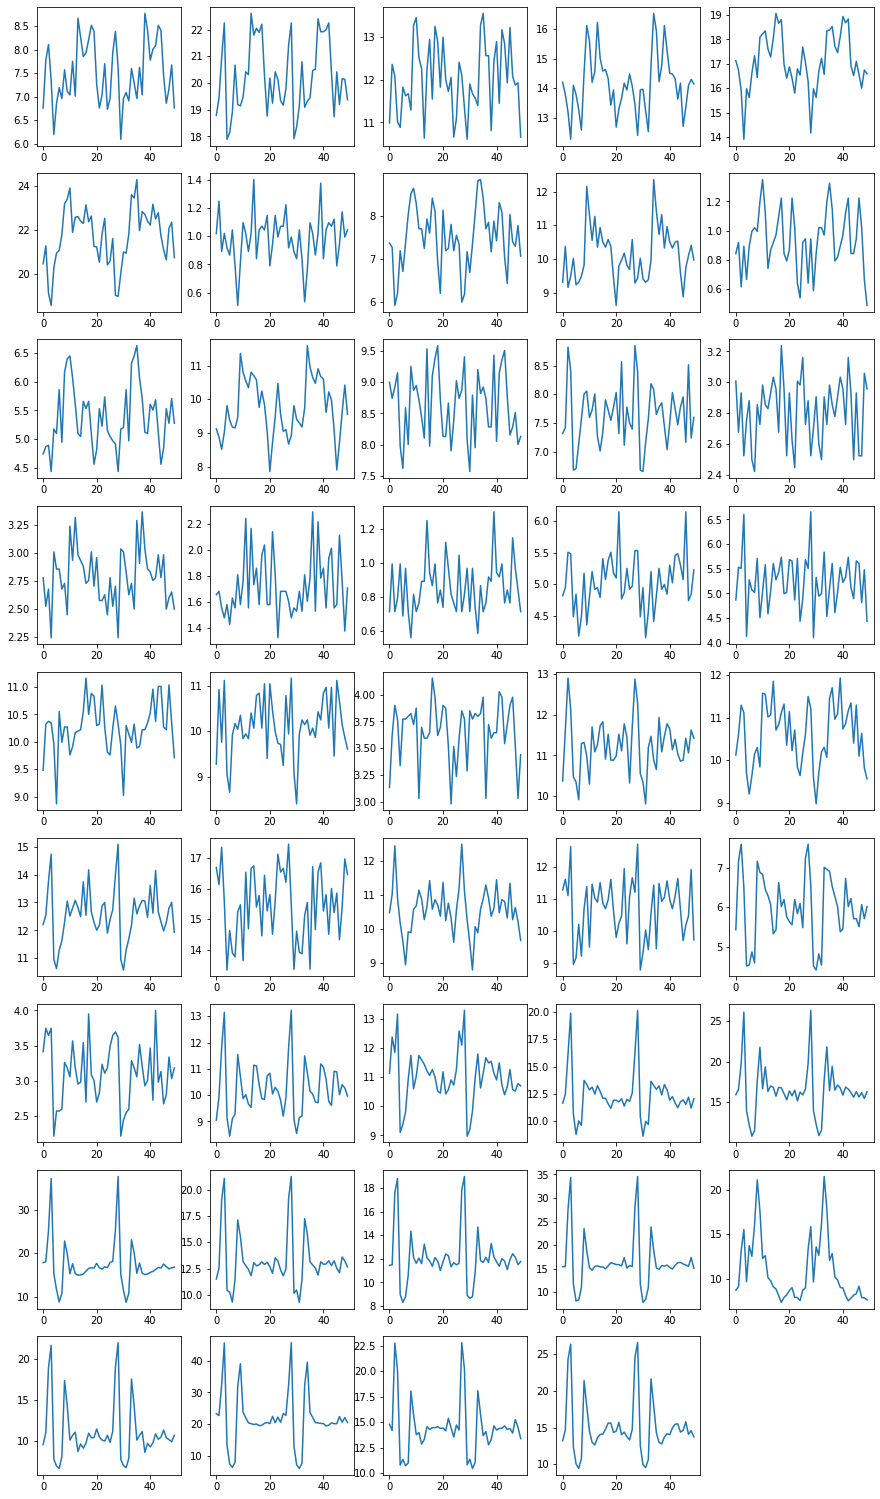

In [283]:
cols = 5
rows = int(len(np.unique(s_clust))/cols) + 1
fig = plt.figure(figsize=(3*cols, 3*rows))

for i, clu_id in enumerate(np.unique(s_clust)):
    s_train = s_times[np.where(s_clust == clu_id)]
    bins, psth = get_spike_counts(s_train/30000., sound_events[sound_events[:, 1] == 1][:, 0])
    
    ax = fig.add_subplot(rows, cols, i+1)
    ax.plot(psth)

In [153]:
spk_per_shank[0].shape

(780889,)